## Initialisation

### Dependencies

#### Third party

In [1]:
from matplotlib import pyplot as plt
import statsmodels.api as sm 
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression 
from scipy import optimize 
from IPython.display import Latex                                                                                                                                                                                                                                                                

#### Personal notebooks

In [2]:
import ipynb
from ipynb.fs.full.dataset_initialisation import (
    x,
    y,
    x_label,
    y_label,
    OUTPUT_DIR,
)
from ipynb.fs.defs.utilities import (
    differentiate,
    group_by,
)

### Notations

- $\sigma \rightarrow$ True Stress
- $\epsilon \rightarrow$ True Strain
- $\epsilon_{pl} \rightarrow$ True Plastic Strain
- $\sigma_{ys} \rightarrow$ Yield Strength
- $\sigma_{uts} \rightarrow$ Ultimate Tensile Strength
- $n \rightarrow$ Work hardening Exponent
- $E \rightarrow$ Young's Modulus
- $K \rightarrow$ Strength Coefficient
- $e \rightarrow$ Engineering Strain
- $s \rightarrow$ Engineering Stress
- $\theta \rightarrow$ Work hardening rate
- $\sigma - \sigma_{ys} \rightarrow$ Flow Stress

## Plot of Engineering Strain v/s Engineering Stress

### Sanitise dataset and plot $e$ v/s $s$

1. Remove the values where $s < 0$.
2. Group multiple values of $s$ corresponding to the same value of $e$.

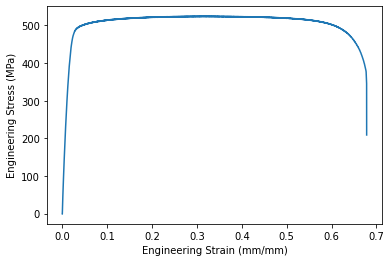

In [3]:
# Remove negative engineering stresses
item = len(x) - 1
delete = []
while item >=0:
  if y[item] < 0:
    delete.append(item)
  item -= 1

x.drop(delete)
y.drop(delete)

# Group duplicates
x, y = group_by(x, y)
plt.xlabel(x_label)
plt.ylabel(y_label)
_ = plt.plot(x,y)
plt.savefig(f'{OUTPUT_DIR}/engineering stress vs strain.png')

### Reduce noise in the curve

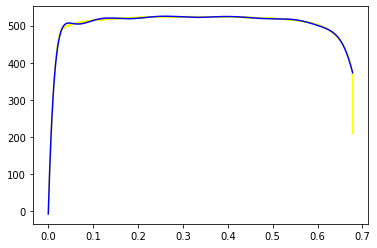

In [4]:
coefficients = np.polyfit(x, y, 13)
y_smooth = np.polyval(coefficients, x)
_ = plt.plot(x,y, color = 'yellow')
_ = plt.plot (x, y_smooth, color = 'blue')

## Calculation of Young's modulus ($E$)

Enter the index of datapoint upto which the line seems linear (used in calculation of Youngs modulus): 600
Young's Modulus: 15.376350321490246 GPa


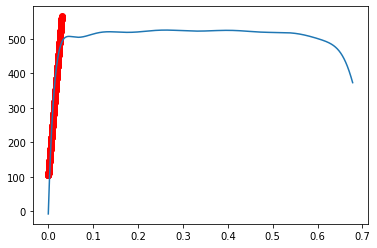

In [11]:
educated_guess = int(input('Enter the index of datapoint upto which the line seems linear (used in calculation of Youngs modulus): '))

x_smooth = sm.add_constant(x) 
result = sm.OLS(y_smooth[:educated_guess], x_smooth[:educated_guess]).fit() 

_, youngs_modulus = result.params

y_linear = [(i*youngs_modulus + _) for i in x]

_ = plt.plot(x[:educated_guess],y_linear[:educated_guess], 'ro')
_ = plt.plot(x,y_smooth)


print(f'Young\'s Modulus: {youngs_modulus/1000} GPa')
plt.savefig(f'{OUTPUT_DIR}/Youngs modulus calculation.png')
file = open (f'{OUTPUT_DIR}/output.txt','w')
file.write ("Young's Modulus = " + repr(youngs_modulus) + " MPa" + '\n')
file.close()

## Calculation of Yield strength ($\sigma_{ys}$)

Yield Strength: 500.0647282069209 MPa


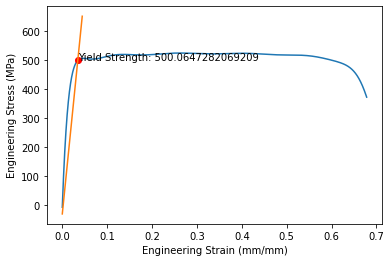

In [12]:
parallel_line_y = [(i - 0.002)*youngs_modulus for i in x]
plt.plot(x,y_smooth)
intersection = np.argwhere(np.diff(np.sign([parallel_line_y[i] - y_smooth[i] for i in range(len(y_smooth))]))).flatten()
plt.plot(x[intersection[0]], y_smooth[intersection[0]], 'ro')

# 200 is added as a scaling factor so that the intersection point is easily viewable
plt.plot(x[:(intersection[0]+200)], parallel_line_y[:(intersection[0]+200)])
plt.xlabel(x_label)
plt.ylabel(y_label)
yield_strength = y_smooth[intersection[0]]
plt.annotate(f'Yield Strength: {yield_strength}', (x[intersection[0]], y_smooth[intersection[0]]))
plt.savefig(f'{OUTPUT_DIR}/Yield Strength calculation.png')
# 0th index because there is only one intersection point
print(f'Yield Strength: {yield_strength} MPa')
file = open (f'{OUTPUT_DIR}/output.txt','a+')
file.write ("Yield Strength = " + repr(yield_strength) + " MPa" +'\n')
file.close()

## Calculation of Ultimate tensile strength ($\sigma_{uts}$)

Ultimate Tensile Strength is 524.53574 MPa at 31.821500000000004% elongation.


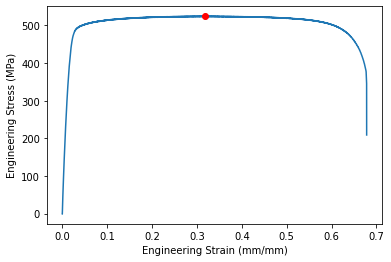

In [13]:
# Fetch the max value of the engineering stress from the dataset.
uts_abscissa = 0
uts = y[uts_abscissa]
for i in range(0,len(y)):
    if y[i] >= uts:
        uts = y[i]
        uts_abscissa = i
uts_strain = x[uts_abscissa]
plt.plot(x,y)
plt.plot(uts_strain, uts, 'ro')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.savefig(f'{OUTPUT_DIR}/UTS calculation.png')
print(f'Ultimate Tensile Strength is {uts} MPa at {uts_strain*100}% elongation.')
file = open (f'{OUTPUT_DIR}/output.txt','a+')
file.write ("Ultimate Tensile Strength = " + repr(uts) + " MPa" +'\n')
file.close()

### Plastic Region

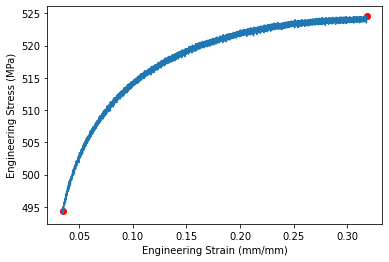

In [14]:
plt.plot(x[intersection[0]], y[intersection[0]], 'ro') # YS
plt.plot(uts_strain, uts, 'ro') # UTS
# there is only one intersection point
start = intersection[0]
end = uts_abscissa+1
plt.plot(x[start:end], y[start:end])
# supresses ouput while setting x,y labels
_ = plt.xlabel(x_label)
_ = plt.ylabel(y_label)